In [357]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt

In [358]:
class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle(max 90 degree)
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)


# P

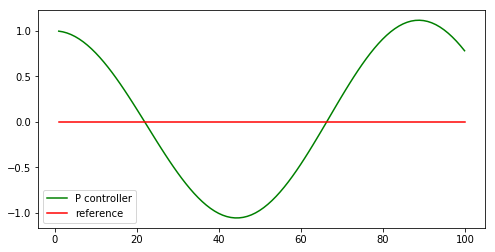

In [359]:
def run(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    
    for _ in range(n):
        steering = -tau*robot.y
        robot.move(steering, speed)
        
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    
    return x_trajectory, y_trajectory

# run - does a single control run
robot = Robot()
robot.set(0.0, 1.0, 0.0)

x_trajectory, y_trajectory = run(robot, 0.1)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='P controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

# PD

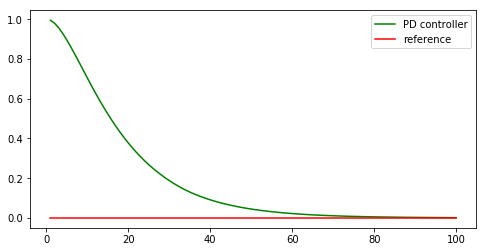

In [360]:
# run - does a single control run
robot = Robot()
robot.set(0, 1, 0)

def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    
    prev_cte = robot.y
    for _ in range(n):
        dev = robot.y - prev_cte
        prev_cte = robot.y
        steer = -tau_p * robot.y - tau_d * dev
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        
    return x_trajectory, y_trajectory

x_trajectory, y_trajectory = run(robot, 0.2, 4)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

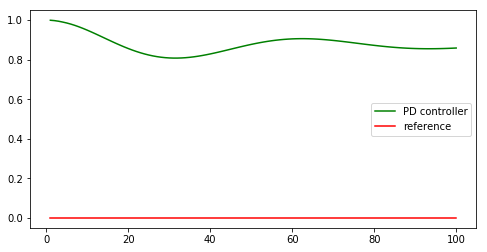

In [361]:
robot = Robot()
robot.set(0, 1, 0)
robot.set_steering_drift(10/180.*np.pi)

def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    
    prev_cte = robot.y
    for _ in range(n):
        dev = robot.y - prev_cte
        prev_cte = robot.y
        steer = -tau_p * robot.y - tau_d * dev
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        
    return x_trajectory, y_trajectory

x_trajectory, y_trajectory = run(robot, 0.2, 1)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

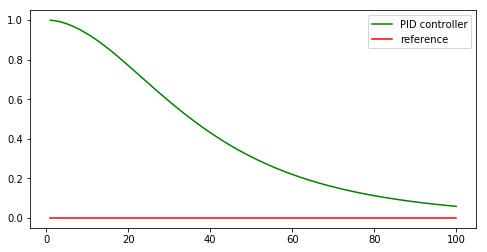

In [362]:
robot = Robot()
robot.set(0, 1, 0)
robot.set_steering_drift(10/180.*np.pi)  # add drift bias

def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    
    prev_cte = robot.y
    sum_cte = 0
    for _ in range(n):
        sum_cte += robot.y
        dev = robot.y - prev_cte
        prev_cte = robot.y
        steer = -tau_p * robot.y - tau_d * dev - tau_i*sum_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        
    return x_trajectory, y_trajectory


x_trajectory, y_trajectory = run(robot, 0.2, 3.0, 0.004)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

In [390]:
def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0.0, 1.0, 0.0)
    robot.set_steering_drift(10.0 / 180.0 * np.pi)
    return robot


def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.1): 
    n = 0
    p = [0.0, 0.0, 0.0]
    dp = [1.0, 1.0, 1.0]
    
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)  # initial err
    
    while sum(dp) >= tol:
        for i in range(len(p)):
            robot = make_robot()
            p[i] += dp[i]
            _, _, err = run(robot, p)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2*dp[i]  # reverse the search direction
                robot = make_robot()
                _, _, err = run(robot, p)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9  # narrow the search range
            n += 1
        if n % 5 == 0:
            print("best err {} | params {} | dparams {}".format(best_err, p, dp))
    
    return p, best_err


params, err = twiddle()
print("Final twiddle error = {}".format(err))

best err 0.052676612588758116 | params [2.9701000000000004, 6.105100000000002, 0.0] | dparams [1.0781100000000003, 1.6105100000000008, 0.5904900000000002]
best err 0.047092602324875193 | params [6.289600690000002, 13.579476910000006, 0.0] | dparams [1.1623211721000006, 2.122152921900002, 0.34867844010000015]
best err 0.047092602324875193 | params [6.289600690000004, 13.579476910000006, 0.0] | dparams [0.6863390289133294, 1.253110078852732, 0.2058911320946491]
best err 0.04664946355807391 | params [7.518833890783777, 16.073165966916942, 0.0] | dparams [0.6054127940141588, 1.1053558694552066, 0.12157665459056936]
best err 0.04621886336471736 | params [8.069698992057264, 19.731893894813673, 0.08862938119652507] | dparams [0.6527015873546049, 1.1916952164183532, 0.08774308738455984]
best err 0.045911572274033745 | params [8.598387277814497, 18.766620769514805, 0.009660602550421227] | dparams [0.471061262609692, 0.8600583546412899, 0.0633250635963107]
best err 0.04578399168856953 | params [

[8.705421418078812, 19.962361956091094, 0.03097419873300903]


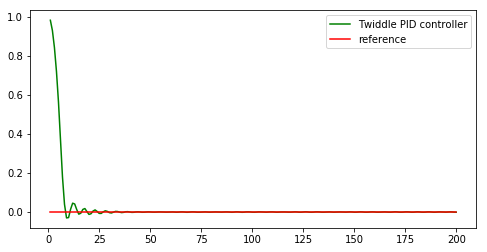

In [400]:
robot = make_robot()
print (params)
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()
fig.savefig('Twidle_null')

In [392]:
def func_to_minimize(parameters):
    robot = make_robot()
    return run(robot, parameters)[2]

In [393]:
varbound=np.array([[5,7], [10,20], [0,1]])
algorithm_param = [[-50, -50,-50], [50,50,50], 0.5, 0.6]

In [394]:
class GA_by_hands(object):
    def __init__(self):
        self.v = list()
        self.F = 0
        self.p = 0
        self.d = 1
        
    def start(self, dimensions, par):
        Xn = np.random.uniform(par[0],par[1], (8*dimensions,dimensions))
        for x in Xn: self.v.append(list(x))
        self.F = par[2]
        self.p = par[3]
        self.d = dimensions
    
    def get_index(self, A):
        return (self.v.index(A))
    
    def Potomki(self, func):
        new_generation = list()
        for x in self.v:
            weights = np.ones(len(self.v))
            weights[self.get_index(x)] = 0
            C = random.choices(self.v, weights = weights, k = 1)
            #print (self.v)
            weights[self.get_index(C[0])] = 0
            A = random.choices(self.v, weights = weights, k = 1)
            weights[self.get_index(A[0])] = 0
            B = random.choices(self.v, weights = weights, k = 1)
            C_new = list(np.array(C) + self.F*(np.array(A) - np.array(B)))[0]
            j = 0
            T = list()
            while j < len(x):
                T.append(random.choices([x[j], C_new[j]], weights = [1-self.p, self.p], k = 1)[0])
                j+= 1
            if (func(T) < func(x)):
                new_generation.append(T)
            else:
                new_generation.append(x)
        self.v = new_generation
        
    def count_min(self, func, iterations):
        i = 0
        while i < iterations:
            self.Potomki(func)
            i+=1
        idol = self.v[0]
        for x in self.v:
            if (func(x)< func(idol)):
                idol = x
        return idol
    
    
        

In [395]:
ga = GA_by_hands()

In [396]:
ga.start(dimensions=3, par =algorithm_param)

In [397]:
res_w = ga.count_min(func_to_minimize, 100)

In [398]:
print (res_w, func_to_minimize(res_w))

[6.936298294649026, 16.22201774505716, 0.031064225769659736] 0.04554111981670368


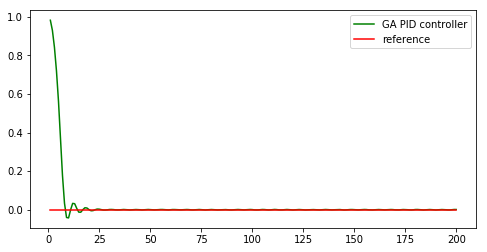

In [401]:
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, res_w)
n = len(x_trajectory)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax1.plot(x_trajectory, y_trajectory, 'g', label='GA PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()
fig.savefig('My_GA_null')